In [4]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d  # noqa: F401
import numpy as np
from sklearn.cluster import KMeans

from sklearn import datasets

### Kmeans with faiss

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import faiss

def kmeans_faiss(datalist, n_clusters, get_plot, plot_distortions_faiss=False, verbose=False):
    X = datalist

    kmeans = faiss.Kmeans(datalist.shape[1], n_clusters, niter=100, verbose=False)
    kmeans.train(X)
    print(f"Overall clustering loss (objective): {kmeans.obj[-1]}")

    if verbose:
        dimensionality = kmeans.index.d
        print(f"Dimensionality of the data: {dimensionality}")

    #get the cluster assignments and distances
    D, I = kmeans.index.search(X, 1)
    labels = I.flatten()  # flatten to get a simple list of labels

    # total distortion (sum of squared distances)
    total_distortion = np.sum(D)
    print(f"Total distortion: {total_distortion}")

    if verbose:
        print(f"labels shape: {labels.shape}")
        print(f"labels: {labels[:5]}")

    if plot_distortions_faiss:
        k = n_clusters
        iterations = 100
        distortions = []

        d = X.shape[1]  # extract the no. of features
        index = faiss.IndexFlatL2(d)  

        clus = faiss.Clustering(d, k)
        clus.verbose = False
        clus.niter = 1
        clus.nredo = 1
        clus.min_points_per_centroid = 1
        clus.max_points_per_centroid = 1000000
        clus.seed = 1234
        clus.spherical = False
        clus.update_index = True

        index = faiss.IndexFlatL2(d)

        clus.train(X, index)
        centroids = faiss.vector_to_array(clus.centroids)
        centroids = centroids.reshape(k, d)

        index.reset()
        index.add(centroids)
        D, _ = index.search(X, 1)
        initial_distortion = np.sum(D)
        normalized_initial_distortion = initial_distortion / (X.shape[0] * d)
        distortions.append(normalized_initial_distortion)

        for i in range(1, iterations):
            clus.train(X, index)
            centroids = faiss.vector_to_array(clus.centroids)
            centroids = centroids.reshape(k, d)
            
            D, _ = index.search(X, 1)
            total_distortion = np.sum(D)
            normalized_distortion = total_distortion / (X.shape[0] * d)
            distortions.append(normalized_distortion)

        plt.figure(figsize=(16, 8))
        plt.plot(range(1, iterations + 1), distortions, marker='x', markersize=5)
        plt.title(f'Distortion vs Iteration for k={n_clusters} with Faiss')
        plt.xlabel('Iteration')
        plt.ylabel('Distortion')
        plt.show()

    grouped_dict = {}
    for i, label in enumerate(labels):
        if label not in grouped_dict:
            grouped_dict[label] = []
        grouped_dict[label].append(X[i])    # grouped_dict = {label: [data_points]} ex: {20 : [3.14 1.19 ....]}

    if get_plot:
        fig = plt.figure(figsize=(28, 20))
        ax = fig.add_subplot(2, 2, 2, projection="3d", elev=48, azim=134)
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels.astype(float), edgecolor="k")
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        ax.zaxis.set_ticklabels([])
        ax.set_title(f'{n_clusters} clusters')
        plt.subplots_adjust(wspace=0.25, hspace=0.25)
        plt.show()

    return labels, kmeans, grouped_dict  

## Organising the structure

### 1. **Data Preparation**

In [6]:
from collections import defaultdict
import pickle
import json 
from sklearn.decomposition import PCA
import numpy as np
import random



def load_data(source, sample_ratio=0.25, verbose=False):
    with open(source, 'rb') as f:
        data = pickle.load(f)

    # Extract MFCC features into a single NumPy array
    all_mfcc_features = []
    for utterance_id, mfcc_features in data.items():
        all_mfcc_features.append(mfcc_features)
    data_array = np.vstack(all_mfcc_features)

    if verbose:
        print(f"Data shape after converting to NumPy array: {data_array.shape}") 
        print("First data point:", data_array[0])


    if sample_ratio < 1:
        random.seed(42)  
        data_subset = random.sample(list(data_array), int(len(data_array) * sample_ratio))
        # convert the sampled data back to a NumPy array
        X = np.array(data_subset)
    else:
        X = data_array  #use the entire dataset

    return X, data

### 2. **CNN Feature Extraction**

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dropout, Dense, MaxPooling2D, Flatten
from tensorflow.keras.regularizers import l2

class CustomCNN(Model):
    def __init__(self, input_shape, dropout_rate=0.5, l2_lambda=0.001, num_classes=39):
        super(CustomCNN, self).__init__()
        self.model = tf.keras.Sequential([
            Conv2D(256, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(l2_lambda)),
            Dropout(dropout_rate),
            Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2_lambda)),
            Dropout(dropout_rate),
            Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_lambda)),
            MaxPooling2D((2, 2)),
            Flatten(),

            Dense(256, activation='relu', kernel_regularizer=l2(l2_lambda)),
            Dropout(dropout_rate),
            Dense(429, activation='relu', kernel_regularizer=l2(l2_lambda)),
            Dropout(dropout_rate),
            Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_lambda))
        ])

    def update_dense_layers(self, backprop_weights, backprop_biases):
        if backprop_weights is not None and backprop_biases is not None:
            for layer, weight, bias in zip(self.model.layers[-6:], backprop_weights, backprop_biases):
                if layer.weights:
                    expected_weight_shape = layer.get_weights()[0].shape
                    expected_bias_shape = layer.get_weights()[1].shape
                    if weight.shape == expected_weight_shape and bias.shape == expected_bias_shape:
                        layer.set_weights([weight, bias])
                    else:
                        print(f"Shape mismatch for layer {layer.name}. Expected weight shape: {expected_weight_shape}, Provided weight shape: {weight.shape}. Expected bias shape: {expected_bias_shape}, Provided bias shape: {bias.shape}. Skipping setting weights and biases.")

    def call(self, inputs):
        return self.model(inputs)

def extract_features_cnn(X, cnn_model=None, verbose=False, backprop_weights=None, backprop_biases=None):
    X_reshaped = X.reshape((-1, 39, 11, 1))  # new shape: (batch_size, 39, 11, 1)
    input_shape = (39, 11, 1)

    if cnn_model is None:
        cnn_model = CustomCNN(input_shape)

    if backprop_weights is not None and backprop_biases is not None:
        cnn_model.update_dense_layers(backprop_weights, backprop_biases)

    if verbose:
        cnn_model.model.summary()

    feature_extractor = tf.keras.Model(inputs=cnn_model.model.inputs, outputs=cnn_model.model.layers[-2].output)
    features = feature_extractor.predict(X_reshaped)

    if verbose:
        print(f"Output shape of CNN: {features.shape}")

    return features, cnn_model

Data shape after converting to NumPy array: (148377, 429)
Overall clustering loss (objective): 1275177.375
Dimensionality of the data: 429
Total distortion: 19230536.0
labels shape: (148377,)
labels: [38 38  6  6  6]


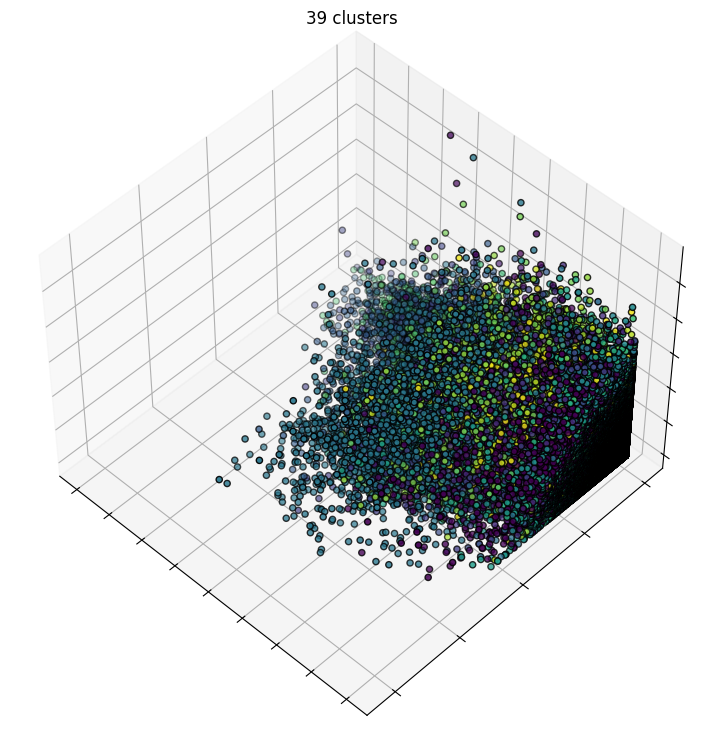

Label: 38
Dimensions: 4838x429
Label: 6
Dimensions: 7809x429
Label: 17
Dimensions: 5304x429
Label: 4
Dimensions: 2114x429
Label: 25
Dimensions: 1970x429
Label: 0
Dimensions: 4311x429
Label: 19
Dimensions: 4708x429
Label: 29
Dimensions: 5299x429
Label: 31
Dimensions: 4452x429
Label: 22
Dimensions: 4948x429
Label: 7
Dimensions: 2574x429
Label: 30
Dimensions: 2397x429
Label: 10
Dimensions: 3915x429
Label: 34
Dimensions: 4903x429
Label: 37
Dimensions: 4370x429
Label: 5
Dimensions: 4329x429
Label: 1
Dimensions: 2271x429
Label: 26
Dimensions: 2849x429
Label: 18
Dimensions: 3215x429
Label: 9
Dimensions: 3984x429
Label: 23
Dimensions: 3207x429
Label: 15
Dimensions: 4501x429
Label: 3
Dimensions: 2529x429
Label: 14
Dimensions: 3760x429
Label: 21
Dimensions: 5367x429
Label: 36
Dimensions: 4821x429
Label: 35
Dimensions: 3991x429
Label: 13
Dimensions: 3667x429
Label: 2
Dimensions: 3250x429
Label: 24
Dimensions: 3247x429
Label: 32
Dimensions: 3559x429
Label: 11
Dimensions: 3992x429
Label: 20
Dimensi

(array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         2.6283789],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         3.0167067],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         2.512499 ],
        ...,
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]], dtype=float32),
 <__main__.CustomCNN at 0x2980445b0>)

In [31]:
n_clusters = 39
X, data = load_data('/Users/dev_feat_encoded.pkl', sample_ratio = 1, verbose = False) 
labels = initial_cluster_data(X, data, 39, CLUSTERS_NUM = 39, dev = 1, verbose=False)
extract_features_cnn(X, verbose=True, labels=labels)

### 3. **Clustering**

In [60]:
from collections import defaultdict
import pickle
import json
import gc  # Garbage collector

def cluster_data(X, data, n_clusters, CLUSTERS_NUM=1, dev=1, iteration=0, verbose=False):
    if verbose:
        print(f"Data shape after converting to NumPy array: {X.shape}")

    # Clustering
    labels, clusterer, grouped_dict = kmeans_faiss(X, n_clusters, get_plot=True, plot_distortions_faiss=True, verbose=verbose)

    if verbose:
        for label, matrix in grouped_dict.items():
            print(f"Label: {label}")
            num_rows = len(matrix)
            num_columns = len(matrix[0])
            print(f'Dimensions: {num_rows}x{num_columns}')

    file_base = 'unsupervised_' + ('dev_' if dev == 1 else 'train_') + 'Encoded' + str(CLUSTERS_NUM)
    file_path = file_base + '.pkl'

    file = ''
    if dev == 1:
        file = 'unsupervised_test_Encoded_new' + str(CLUSTERS_NUM) + '.pkl'
    else:
        file = 'unsupervised_train_Encoded' + str(CLUSTERS_NUM) + '.pkl'

    with open(file, 'wb') as f:
        pickle.dump(grouped_dict, f)

    # Produce the text file after the 4th iteration (i.e., when iteration == 4)
    if iteration == 6 and dev == 1 and (CLUSTERS_NUM == 1 or CLUSTERS_NUM == 40 or CLUSTERS_NUM == 10 or CLUSTERS_NUM == 2 or CLUSTERS_NUM == 39):
        feature_dimension = X.shape[1]
        clusterlabel = defaultdict(list)
        for key in data:
            for value in data[key]:
                if value.size != feature_dimension:
                    print(f"Value with unexpected shape: {value.shape}")
                # Reshape data point before assigning a cluster label
                value_reshaped = value.reshape(1, feature_dimension)
                D, I = clusterer.index.search(value_reshaped, 1)
                cluster_label = I.flatten()[0]
                clusterlabel[key].append(int(cluster_label))
        file = 'dev_labels_Encoded_new_new1' + str(CLUSTERS_NUM) + '.txt'
        with open(file, 'w') as convert_file:
            convert_file.write(json.dumps(clusterlabel))

    return labels

### 4. **Classification Head**

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

def build_classification_head(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(256, activation='relu')(inputs)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(39, activation='softmax')(x)  
    model = Model(inputs=inputs, outputs=outputs)
    return model

### - Train Classification head

In [54]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.legacy import Adam

seed = 42

def train_classification_model(X_features, pseudo_labels, input_shape, n_clusters):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    classification_model = build_classification_head(input_shape)
    classification_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    pseudo_labels = to_categorical(pseudo_labels, num_classes=n_clusters)
    history = classification_model.fit(X_features, pseudo_labels, epochs=150, validation_split=0.2, verbose=1)
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return classification_model

### 5. **Training Loop**

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 37, 9, 256)        2560      
                                                                 
 dropout_138 (Dropout)       (None, 37, 9, 256)        0         
                                                                 
 conv2d_55 (Conv2D)          (None, 35, 7, 128)        295040    
                                                                 
 dropout_139 (Dropout)       (None, 35, 7, 128)        0         
                                                                 
 conv2d_56 (Conv2D)          (None, 33, 5, 64)         73792     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 16, 2, 64)         0         
 ng2D)                                                           
                                                     

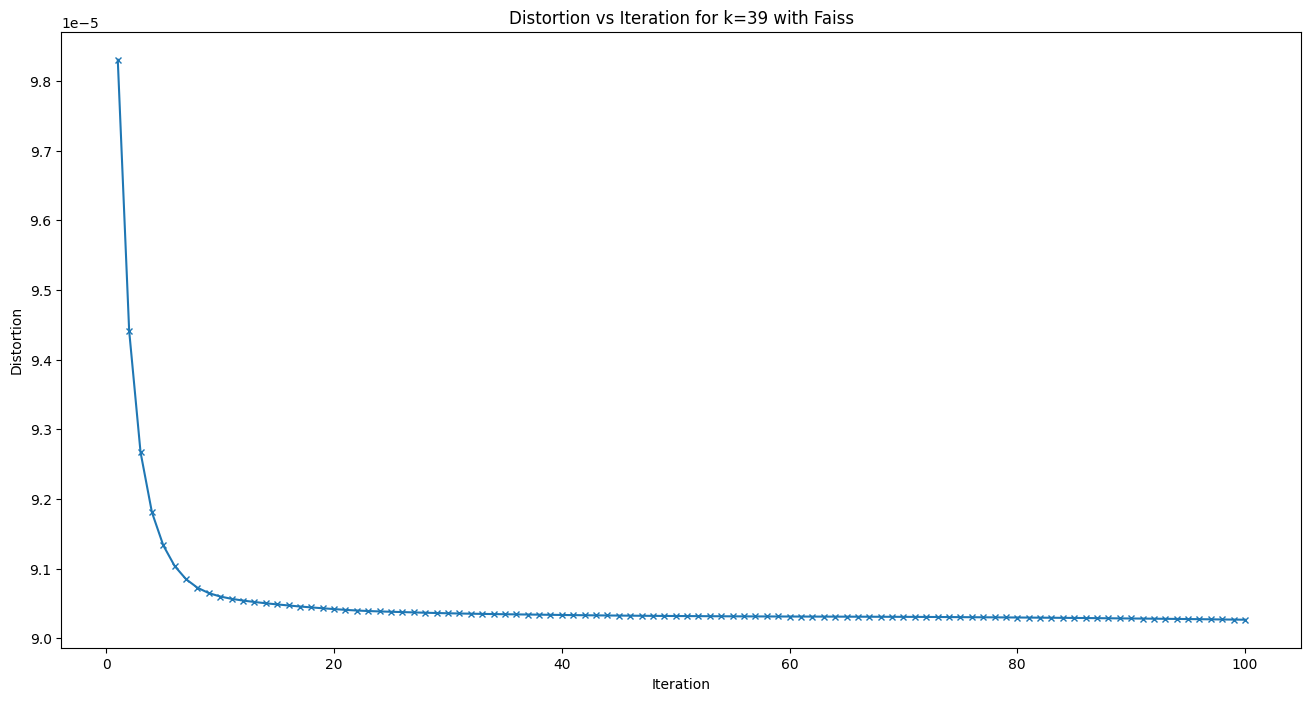

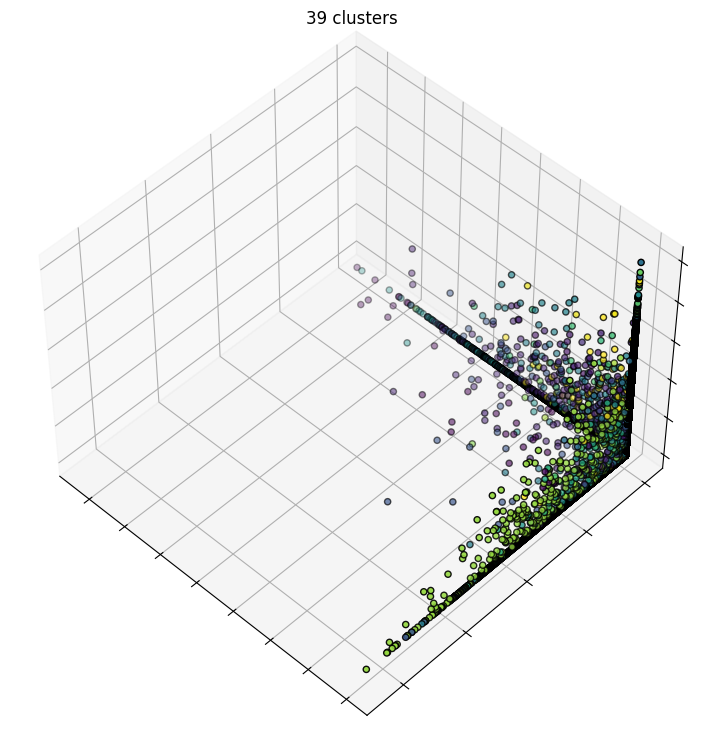

Epoch 1/150


/Users/samanthajohn/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3710/3710 [==============================] - 5s 1ms/step - loss: 2.8130 - accuracy: 0.2265 - val_loss: 1.6960 - val_accuracy: 0.5422
Epoch 2/150
3710/3710 [==============================] - 4s 1ms/step - loss: 1.6334 - accuracy: 0.4676 - val_loss: 1.0556 - val_accuracy: 0.6971
Epoch 3/150
3710/3710 [==============================] - 4s 1ms/step - loss: 1.2676 - accuracy: 0.5699 - val_loss: 0.8275 - val_accuracy: 0.7556
Epoch 4/150
3710/3710 [==============================] - 4s 1ms/step - loss: 1.0772 - accuracy: 0.6306 - val_loss: 0.6967 - val_accuracy: 0.7897
Epoch 5/150
3710/3710 [==============================] - 4s 1ms/step - loss: 0.9673 - accuracy: 0.6639 - val_loss: 0.6284 - val_accuracy: 0.8057
Epoch 6/150
3710/3710 [==============================] - 4s 1ms/step - loss: 0.8872 - accuracy: 0.6905 - val_loss: 0.5712 - val_accuracy: 0.8206
Epoch 7/150
3710/3710 [==============================] - 4s 1ms/step - loss: 0.8274 - accuracy: 0.7094 - val_loss: 0.5232 - val_accuracy: 0.83

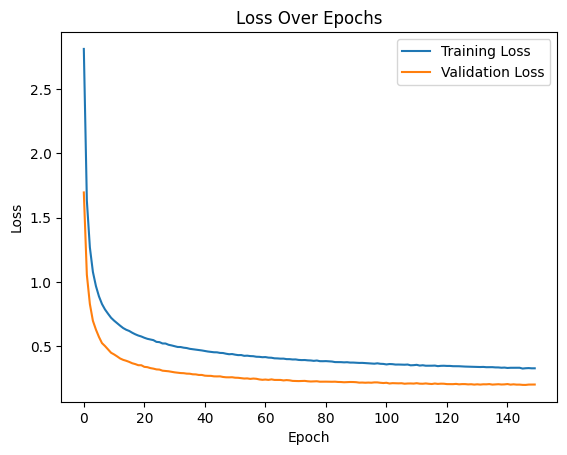

1/1 [==============================] - 0s 10ms/step


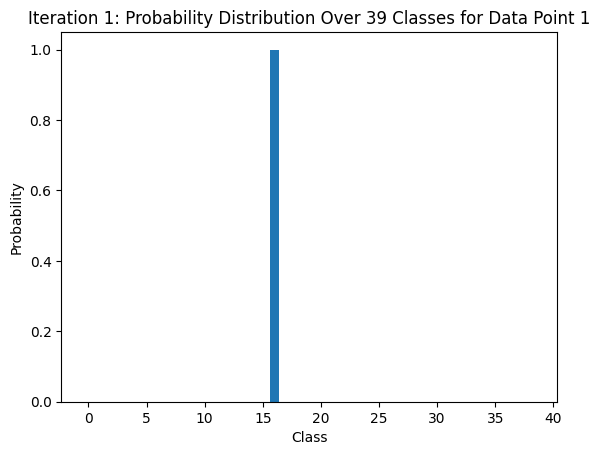

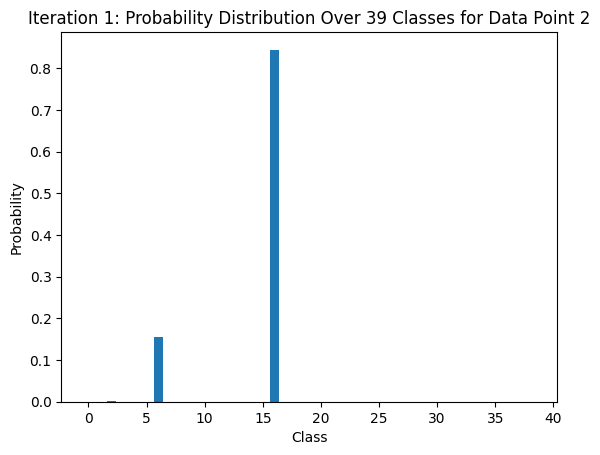

Shape mismatch for layer dense_153. Expected weight shape: (2048, 256), Provided weight shape: (256, 128). Expected bias shape: (256,), Provided bias shape: (128,). Skipping setting weights and biases.
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 37, 9, 256)        2560      
                                                                 
 dropout_138 (Dropout)       (None, 37, 9, 256)        0         
                                                                 
 conv2d_55 (Conv2D)          (None, 35, 7, 128)        295040    
                                                                 
 dropout_139 (Dropout)       (None, 35, 7, 128)        0         
                                                                 
 conv2d_56 (Conv2D)          (None, 33, 5, 64)         73792     
                                                 

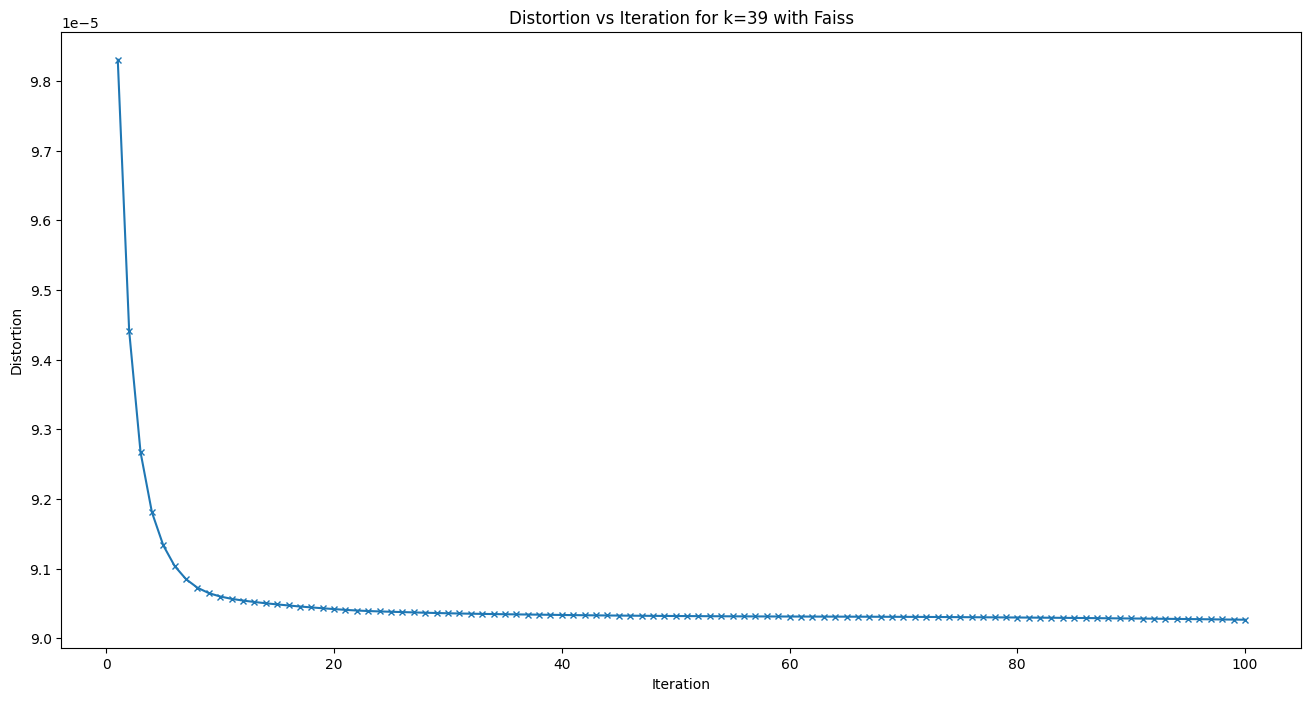

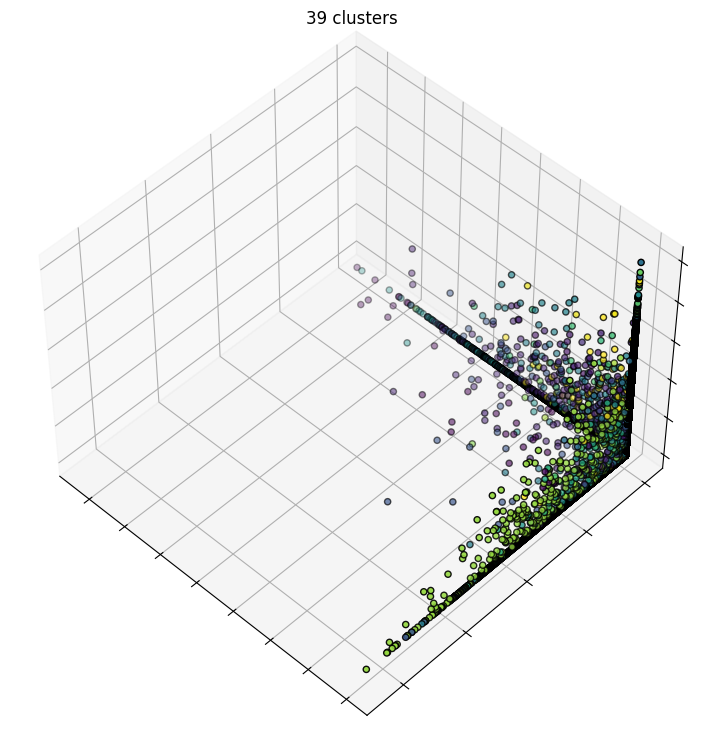

Epoch 1/150


/Users/samanthajohn/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3710/3710 [==============================] - 5s 1ms/step - loss: 2.7866 - accuracy: 0.2325 - val_loss: 1.6232 - val_accuracy: 0.5687
Epoch 2/150
3710/3710 [==============================] - 4s 1ms/step - loss: 1.5866 - accuracy: 0.4761 - val_loss: 1.0237 - val_accuracy: 0.7099
Epoch 3/150
3710/3710 [==============================] - 4s 1ms/step - loss: 1.2326 - accuracy: 0.5794 - val_loss: 0.8135 - val_accuracy: 0.7552
Epoch 4/150
3710/3710 [==============================] - 4s 1ms/step - loss: 1.0588 - accuracy: 0.6318 - val_loss: 0.6921 - val_accuracy: 0.7906
Epoch 5/150
3710/3710 [==============================] - 4s 1ms/step - loss: 0.9487 - accuracy: 0.6697 - val_loss: 0.6203 - val_accuracy: 0.8106
Epoch 6/150
3710/3710 [==============================] - 4s 1ms/step - loss: 0.8735 - accuracy: 0.6947 - val_loss: 0.5641 - val_accuracy: 0.8211
Epoch 7/150
3710/3710 [==============================] - 4s 1ms/step - loss: 0.8190 - accuracy: 0.7117 - val_loss: 0.5216 - val_accuracy: 0.83

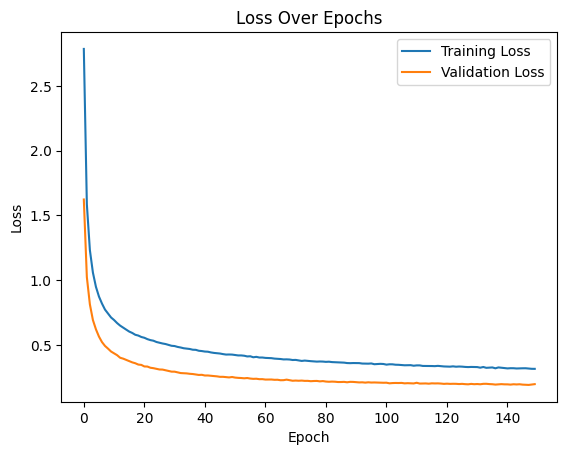

1/1 [==============================] - 0s 9ms/step


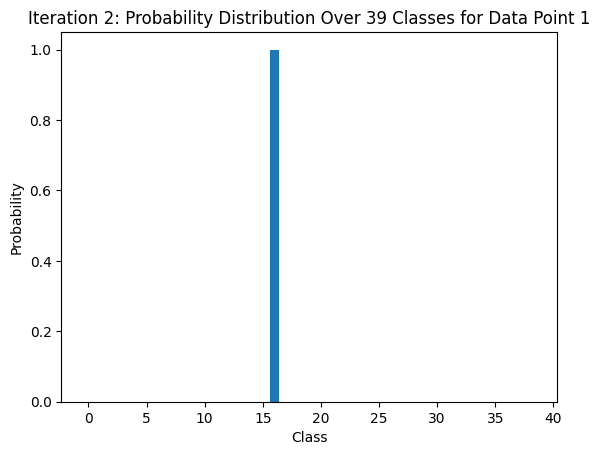

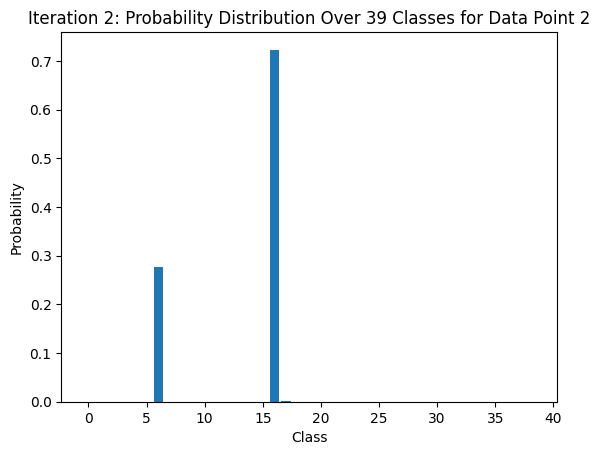

Shape mismatch for layer dense_153. Expected weight shape: (2048, 256), Provided weight shape: (256, 128). Expected bias shape: (256,), Provided bias shape: (128,). Skipping setting weights and biases.
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 37, 9, 256)        2560      
                                                                 
 dropout_138 (Dropout)       (None, 37, 9, 256)        0         
                                                                 
 conv2d_55 (Conv2D)          (None, 35, 7, 128)        295040    
                                                                 
 dropout_139 (Dropout)       (None, 35, 7, 128)        0         
                                                                 
 conv2d_56 (Conv2D)          (None, 33, 5, 64)         73792     
                                                 

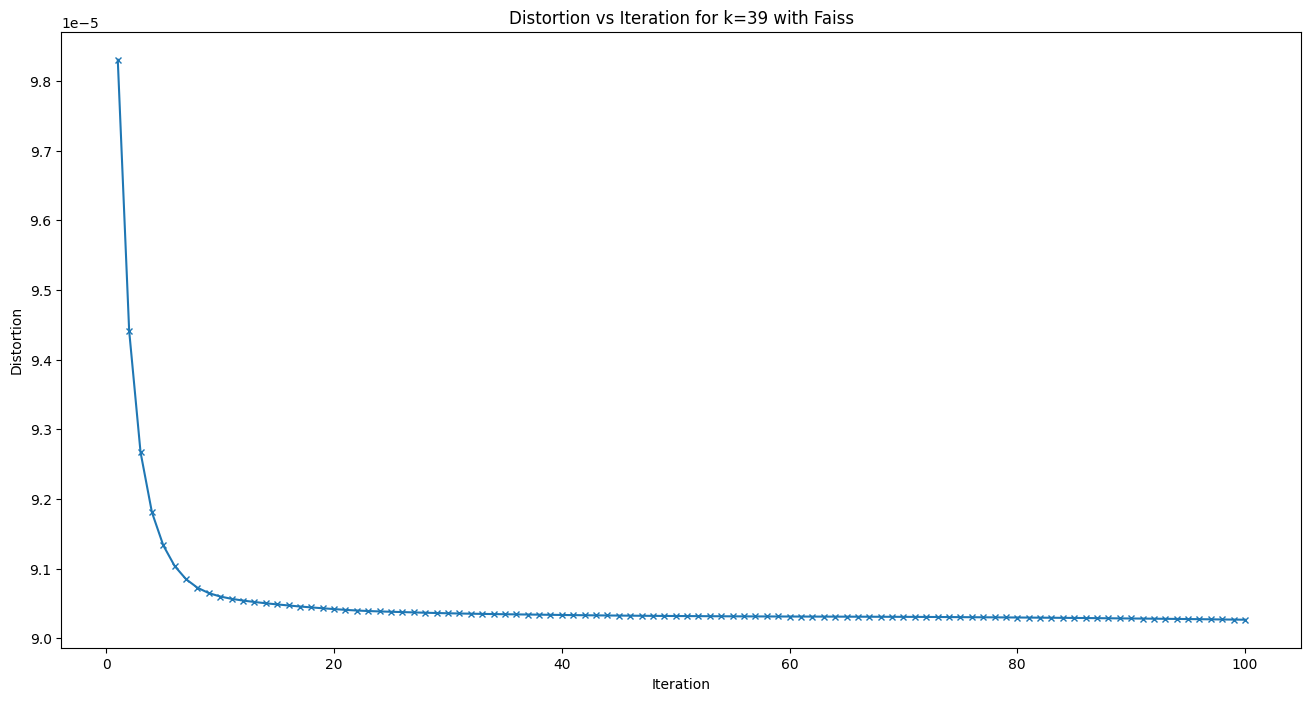

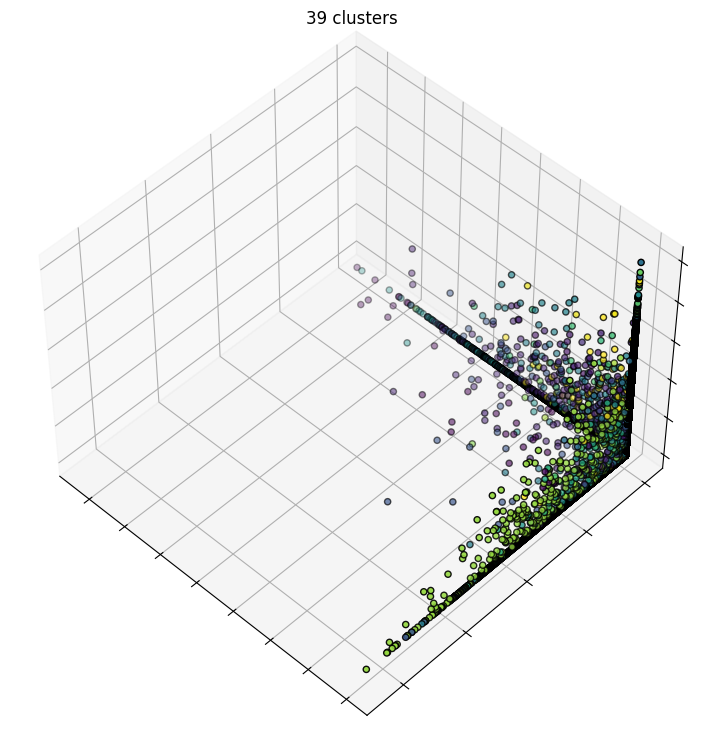

Epoch 1/150


/Users/samanthajohn/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3710/3710 [==============================] - 1071s 1ms/step - loss: 2.8113 - accuracy: 0.2222 - val_loss: 1.7077 - val_accuracy: 0.5654
Epoch 2/150
3710/3710 [==============================] - 1075s 290ms/step - loss: 1.6389 - accuracy: 0.4639 - val_loss: 1.0678 - val_accuracy: 0.6979
Epoch 3/150
3710/3710 [==============================] - 957s 258ms/step - loss: 1.2759 - accuracy: 0.5660 - val_loss: 0.8414 - val_accuracy: 0.7459
Epoch 4/150
3710/3710 [==============================] - 6s 2ms/step - loss: 1.0950 - accuracy: 0.6224 - val_loss: 0.7114 - val_accuracy: 0.7812
Epoch 5/150
3710/3710 [==============================] - 5s 1ms/step - loss: 0.9798 - accuracy: 0.6602 - val_loss: 0.6375 - val_accuracy: 0.8009
Epoch 6/150
3710/3710 [==============================] - 5s 1ms/step - loss: 0.9013 - accuracy: 0.6856 - val_loss: 0.5805 - val_accuracy: 0.8162
Epoch 7/150
3710/3710 [==============================] - 5s 1ms/step - loss: 0.8410 - accuracy: 0.7033 - val_loss: 0.5380 - val_ac

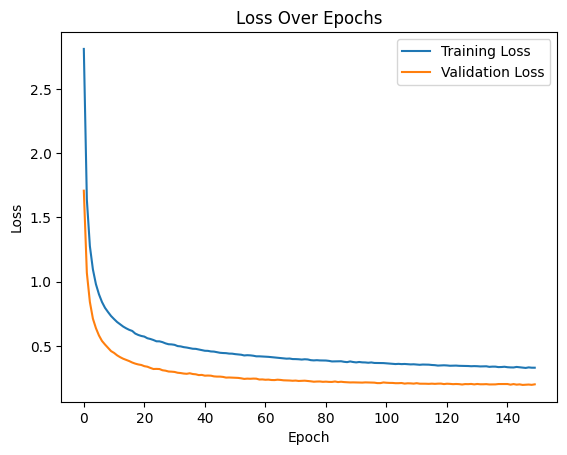

1/1 [==============================] - 0s 9ms/step


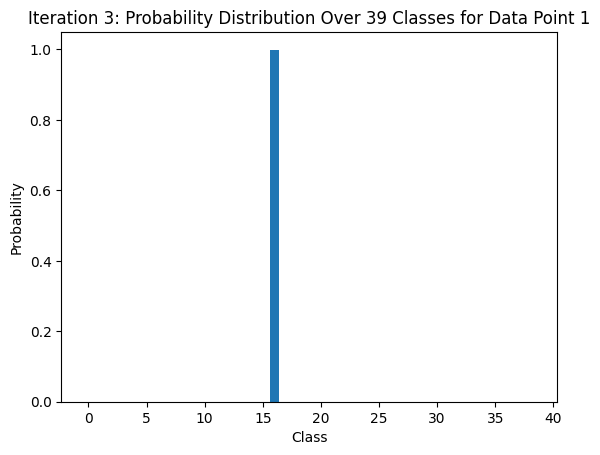

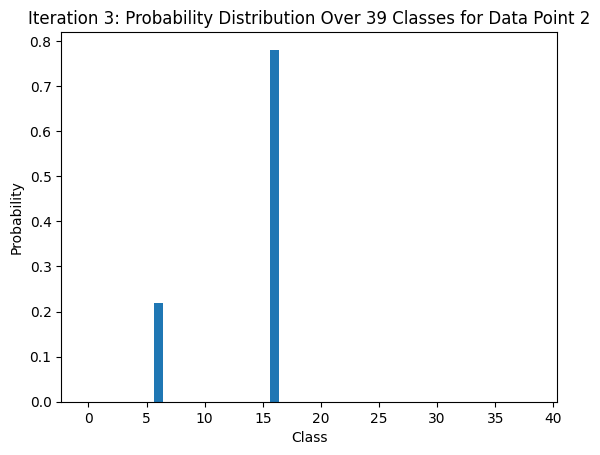

Shape mismatch for layer dense_153. Expected weight shape: (2048, 256), Provided weight shape: (256, 128). Expected bias shape: (256,), Provided bias shape: (128,). Skipping setting weights and biases.
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 37, 9, 256)        2560      
                                                                 
 dropout_138 (Dropout)       (None, 37, 9, 256)        0         
                                                                 
 conv2d_55 (Conv2D)          (None, 35, 7, 128)        295040    
                                                                 
 dropout_139 (Dropout)       (None, 35, 7, 128)        0         
                                                                 
 conv2d_56 (Conv2D)          (None, 33, 5, 64)         73792     
                                                 

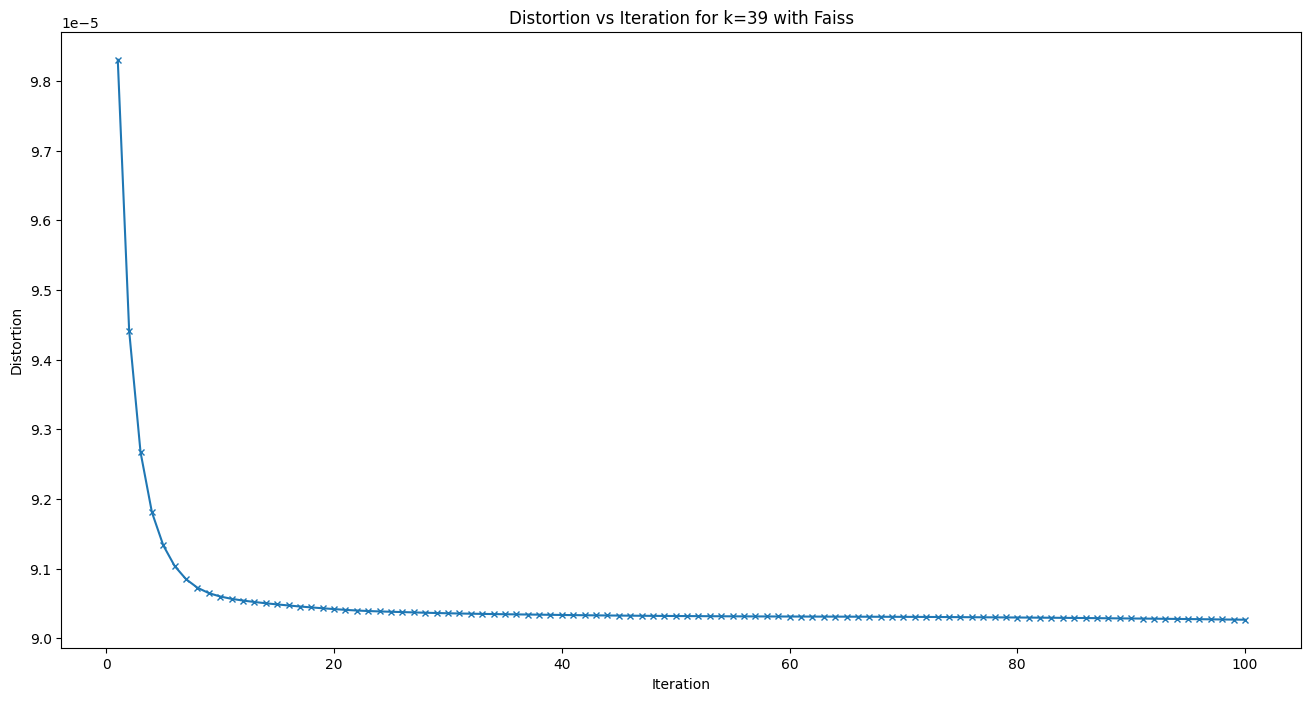

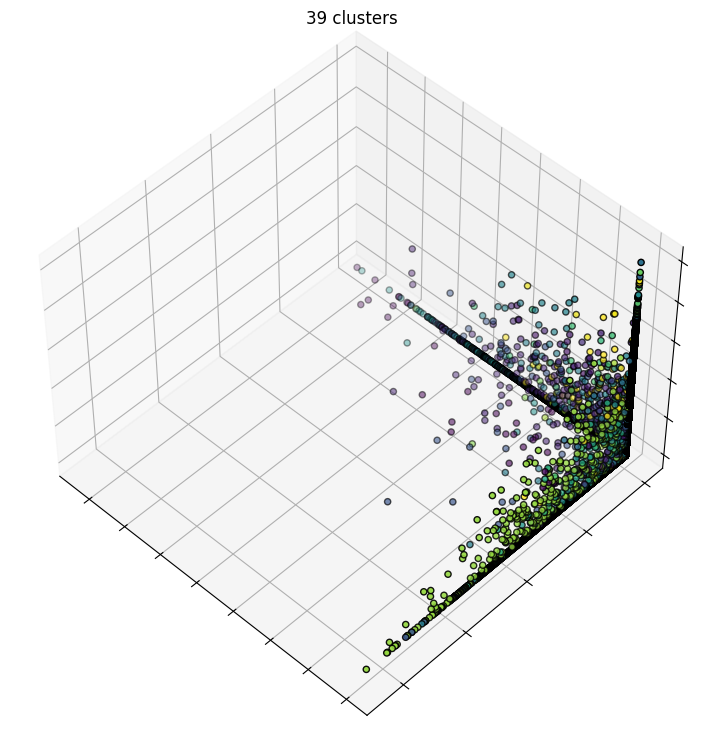

Epoch 1/150


/Users/samanthajohn/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3710/3710 [==============================] - 5s 1ms/step - loss: 2.7998 - accuracy: 0.2174 - val_loss: 1.7289 - val_accuracy: 0.5375
Epoch 2/150
3710/3710 [==============================] - 4s 1ms/step - loss: 1.6729 - accuracy: 0.4553 - val_loss: 1.0947 - val_accuracy: 0.6882
Epoch 3/150
3710/3710 [==============================] - 4s 1ms/step - loss: 1.2935 - accuracy: 0.5605 - val_loss: 0.8516 - val_accuracy: 0.7448
Epoch 4/150
3710/3710 [==============================] - 4s 1ms/step - loss: 1.1008 - accuracy: 0.6209 - val_loss: 0.7136 - val_accuracy: 0.7850
Epoch 5/150
3710/3710 [==============================] - 4s 1ms/step - loss: 0.9870 - accuracy: 0.6600 - val_loss: 0.6343 - val_accuracy: 0.8068
Epoch 6/150
3710/3710 [==============================] - 4s 1ms/step - loss: 0.9048 - accuracy: 0.6846 - val_loss: 0.5801 - val_accuracy: 0.8209
Epoch 7/150
3710/3710 [==============================] - 4s 1ms/step - loss: 0.8489 - accuracy: 0.7010 - val_loss: 0.5349 - val_accuracy: 0.83

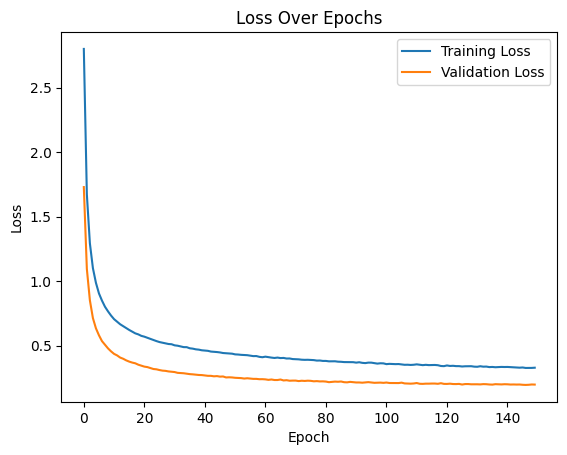

1/1 [==============================] - 0s 9ms/step


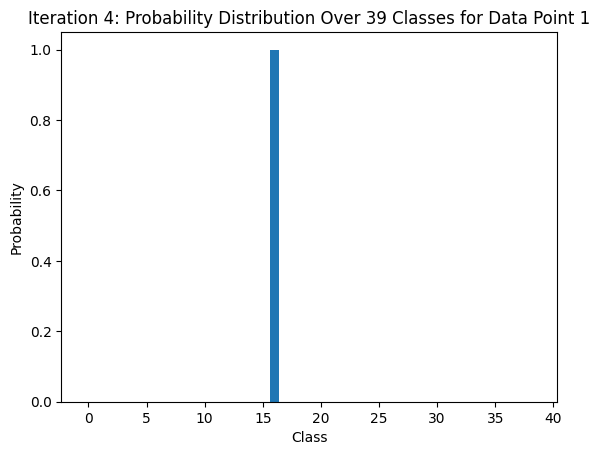

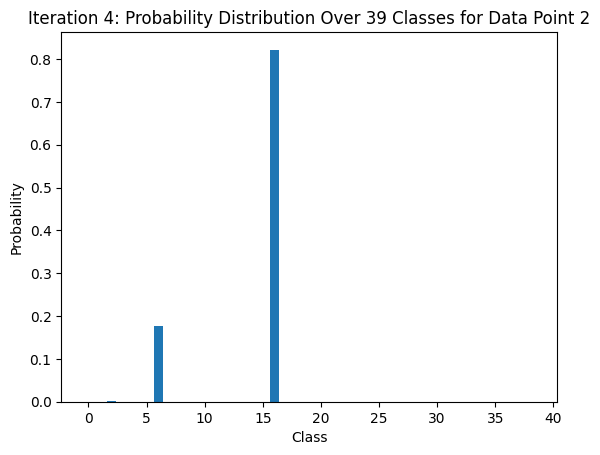

Shape mismatch for layer dense_153. Expected weight shape: (2048, 256), Provided weight shape: (256, 128). Expected bias shape: (256,), Provided bias shape: (128,). Skipping setting weights and biases.
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 37, 9, 256)        2560      
                                                                 
 dropout_138 (Dropout)       (None, 37, 9, 256)        0         
                                                                 
 conv2d_55 (Conv2D)          (None, 35, 7, 128)        295040    
                                                                 
 dropout_139 (Dropout)       (None, 35, 7, 128)        0         
                                                                 
 conv2d_56 (Conv2D)          (None, 33, 5, 64)         73792     
                                                 

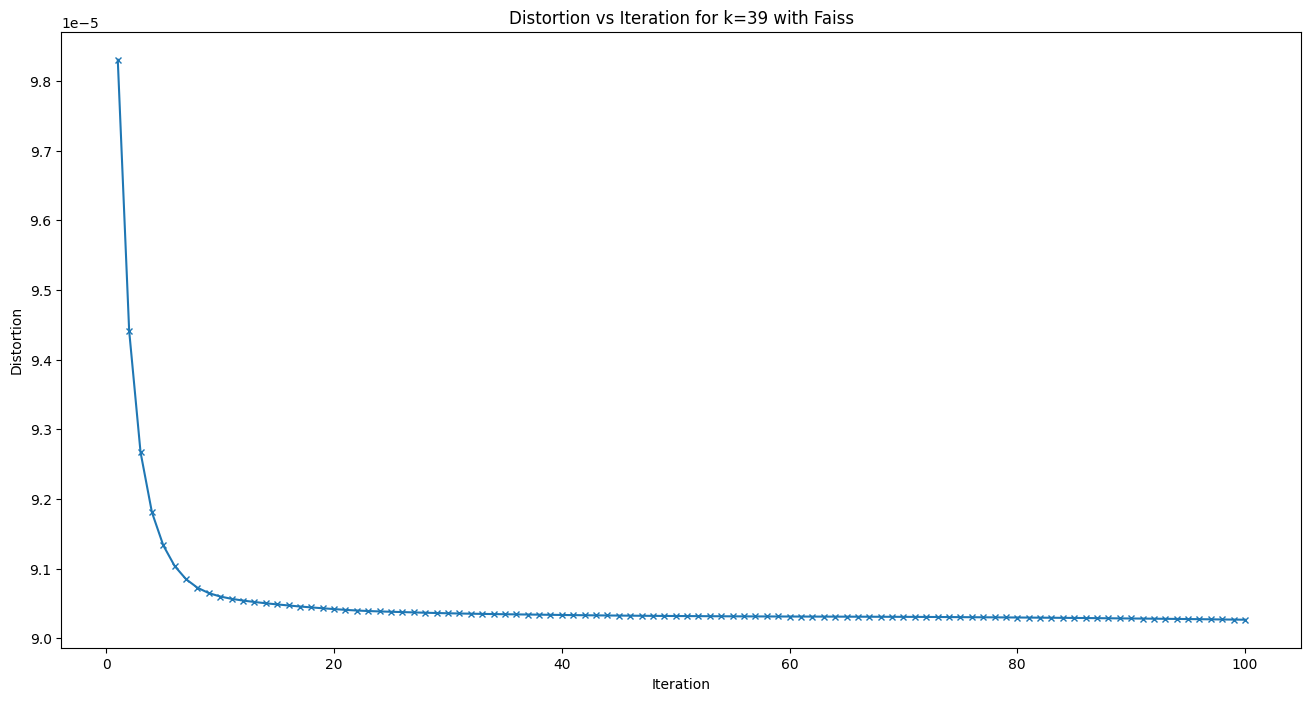

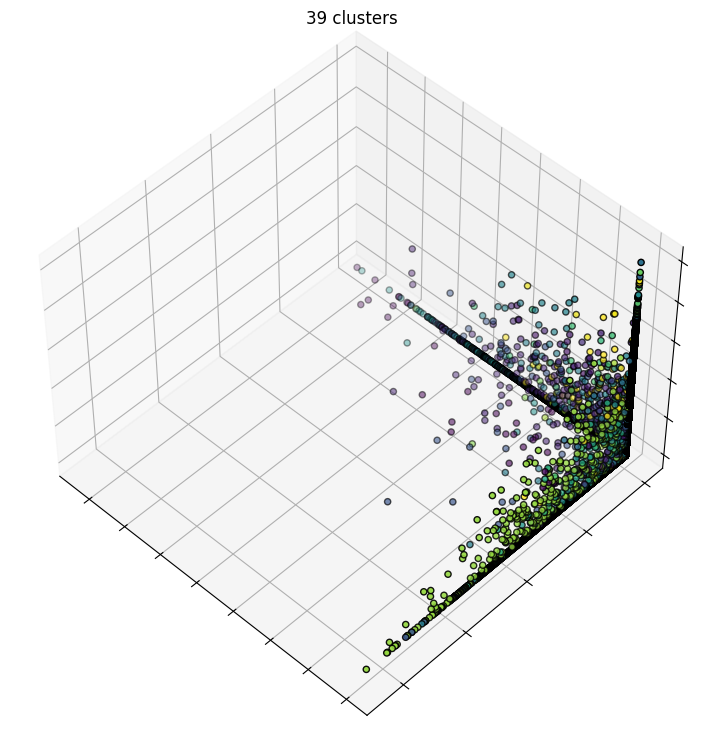

Epoch 1/150


/Users/samanthajohn/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3710/3710 [==============================] - 5s 1ms/step - loss: 2.7894 - accuracy: 0.2271 - val_loss: 1.6669 - val_accuracy: 0.5549
Epoch 2/150
3710/3710 [==============================] - 4s 1ms/step - loss: 1.6019 - accuracy: 0.4770 - val_loss: 1.0320 - val_accuracy: 0.7080
Epoch 3/150
3710/3710 [==============================] - 4s 1ms/step - loss: 1.2388 - accuracy: 0.5800 - val_loss: 0.8140 - val_accuracy: 0.7599
Epoch 4/150
3710/3710 [==============================] - 4s 1ms/step - loss: 1.0519 - accuracy: 0.6369 - val_loss: 0.6813 - val_accuracy: 0.7945
Epoch 5/150
3710/3710 [==============================] - 4s 1ms/step - loss: 0.9410 - accuracy: 0.6719 - val_loss: 0.6054 - val_accuracy: 0.8122
Epoch 6/150
3710/3710 [==============================] - 4s 1ms/step - loss: 0.8655 - accuracy: 0.6948 - val_loss: 0.5542 - val_accuracy: 0.8277
Epoch 7/150
3710/3710 [==============================] - 4s 1ms/step - loss: 0.8116 - accuracy: 0.7146 - val_loss: 0.5117 - val_accuracy: 0.84

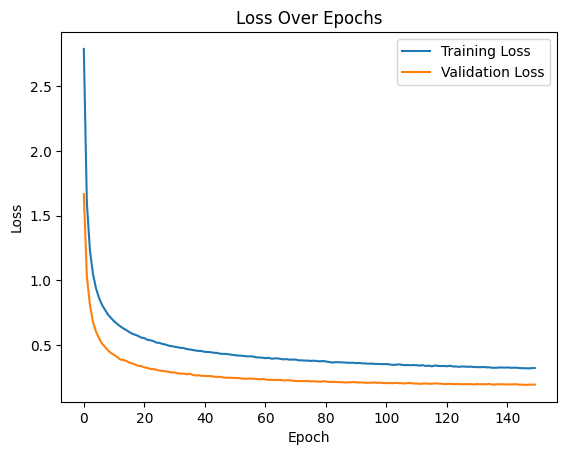

1/1 [==============================] - 0s 10ms/step


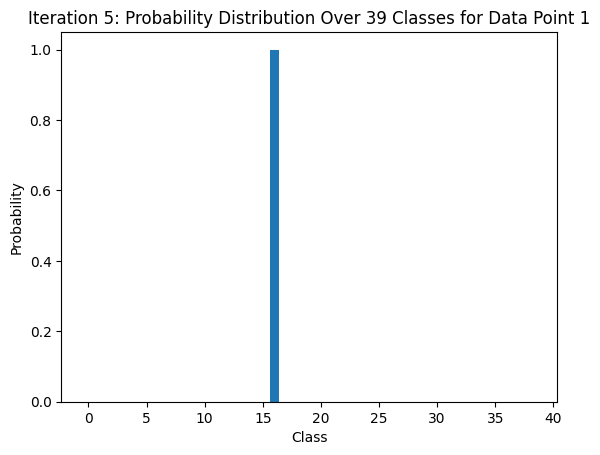

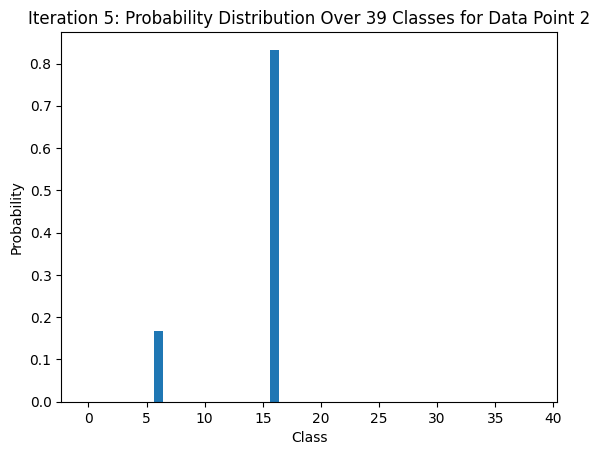

Shape mismatch for layer dense_153. Expected weight shape: (2048, 256), Provided weight shape: (256, 128). Expected bias shape: (256,), Provided bias shape: (128,). Skipping setting weights and biases.
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 37, 9, 256)        2560      
                                                                 
 dropout_138 (Dropout)       (None, 37, 9, 256)        0         
                                                                 
 conv2d_55 (Conv2D)          (None, 35, 7, 128)        295040    
                                                                 
 dropout_139 (Dropout)       (None, 35, 7, 128)        0         
                                                                 
 conv2d_56 (Conv2D)          (None, 33, 5, 64)         73792     
                                                 

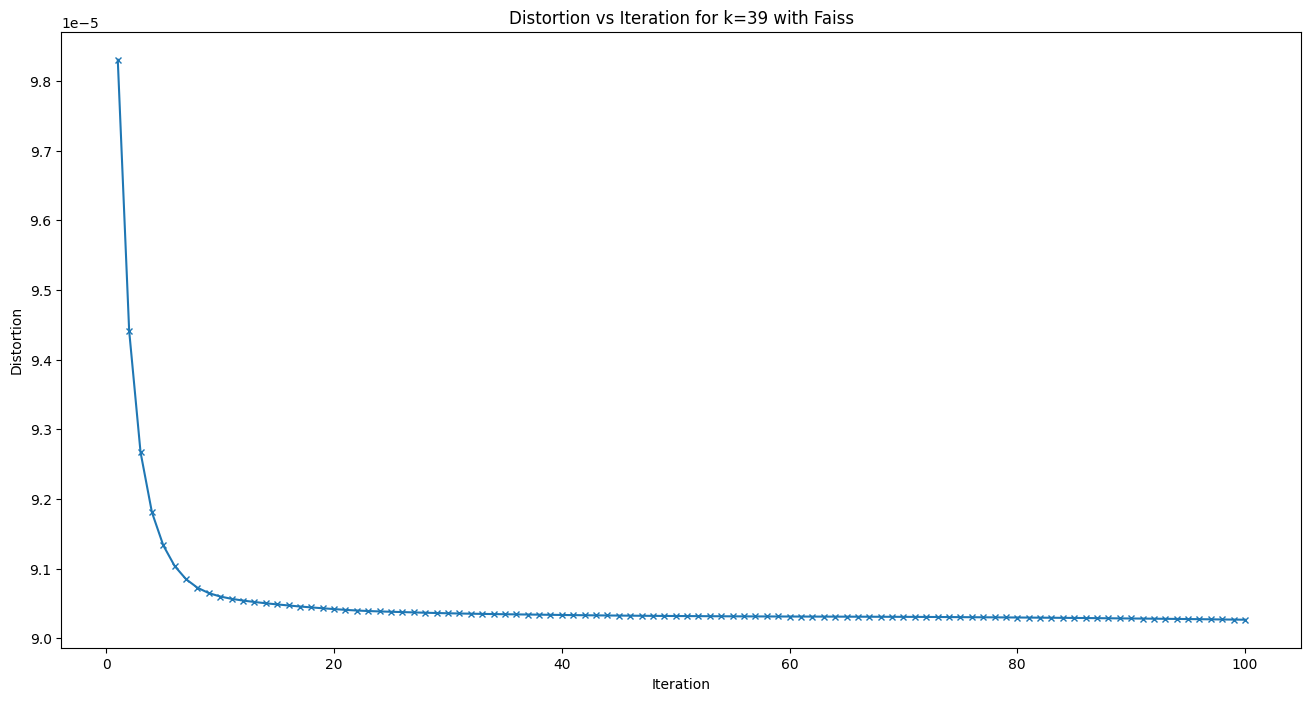

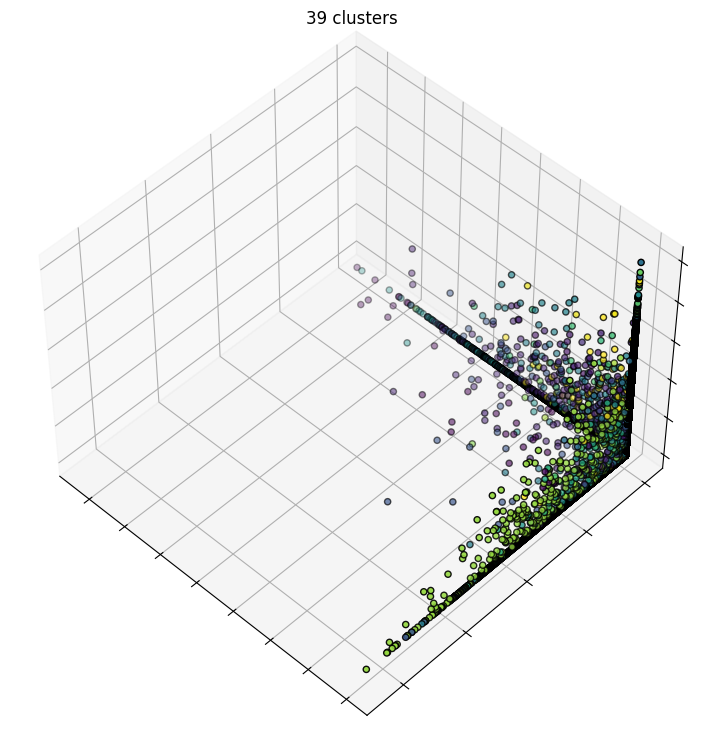

Epoch 1/150


/Users/samanthajohn/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3710/3710 [==============================] - 5s 1ms/step - loss: 2.7980 - accuracy: 0.2242 - val_loss: 1.6696 - val_accuracy: 0.5393
Epoch 2/150
3710/3710 [==============================] - 5s 1ms/step - loss: 1.6388 - accuracy: 0.4601 - val_loss: 1.0784 - val_accuracy: 0.6834
Epoch 3/150
3710/3710 [==============================] - 5s 1ms/step - loss: 1.2882 - accuracy: 0.5624 - val_loss: 0.8564 - val_accuracy: 0.7392
Epoch 4/150
3710/3710 [==============================] - 5s 1ms/step - loss: 1.1048 - accuracy: 0.6182 - val_loss: 0.7217 - val_accuracy: 0.7778
Epoch 5/150
3710/3710 [==============================] - 5s 1ms/step - loss: 0.9851 - accuracy: 0.6588 - val_loss: 0.6443 - val_accuracy: 0.8010
Epoch 6/150
3710/3710 [==============================] - 5s 1ms/step - loss: 0.9051 - accuracy: 0.6850 - val_loss: 0.5817 - val_accuracy: 0.8175
Epoch 7/150
3710/3710 [==============================] - 5s 1ms/step - loss: 0.8431 - accuracy: 0.7047 - val_loss: 0.5400 - val_accuracy: 0.83

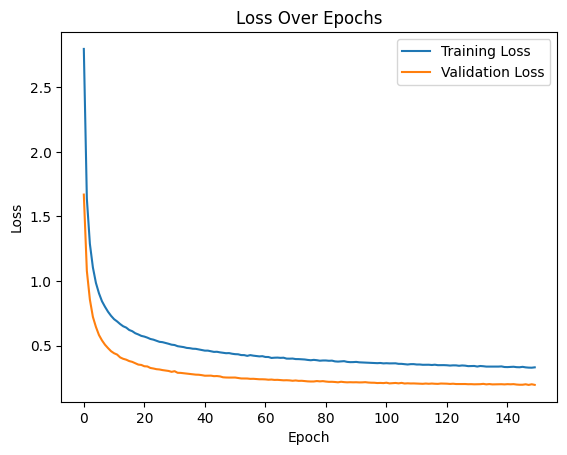

1/1 [==============================] - 0s 9ms/step


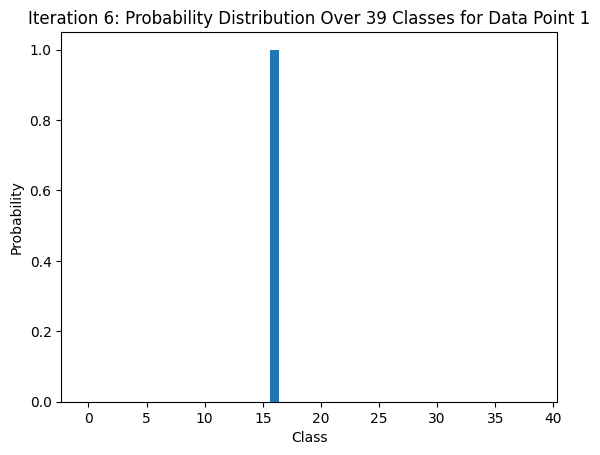

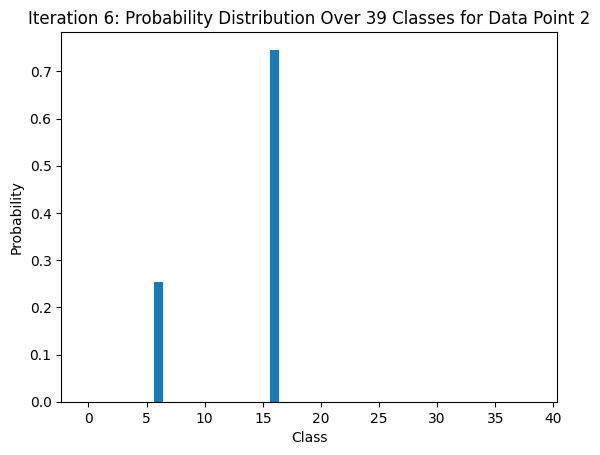

Shape mismatch for layer dense_153. Expected weight shape: (2048, 256), Provided weight shape: (256, 128). Expected bias shape: (256,), Provided bias shape: (128,). Skipping setting weights and biases.
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 37, 9, 256)        2560      
                                                                 
 dropout_138 (Dropout)       (None, 37, 9, 256)        0         
                                                                 
 conv2d_55 (Conv2D)          (None, 35, 7, 128)        295040    
                                                                 
 dropout_139 (Dropout)       (None, 35, 7, 128)        0         
                                                                 
 conv2d_56 (Conv2D)          (None, 33, 5, 64)         73792     
                                                 

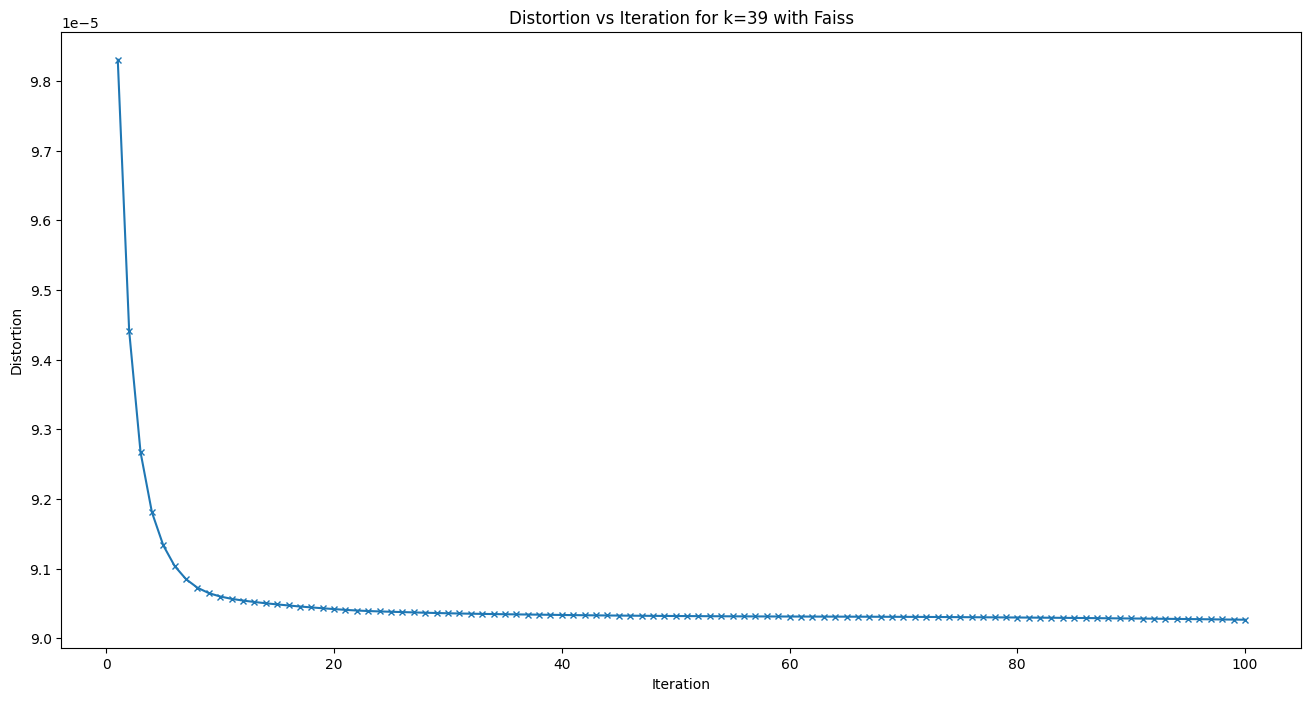

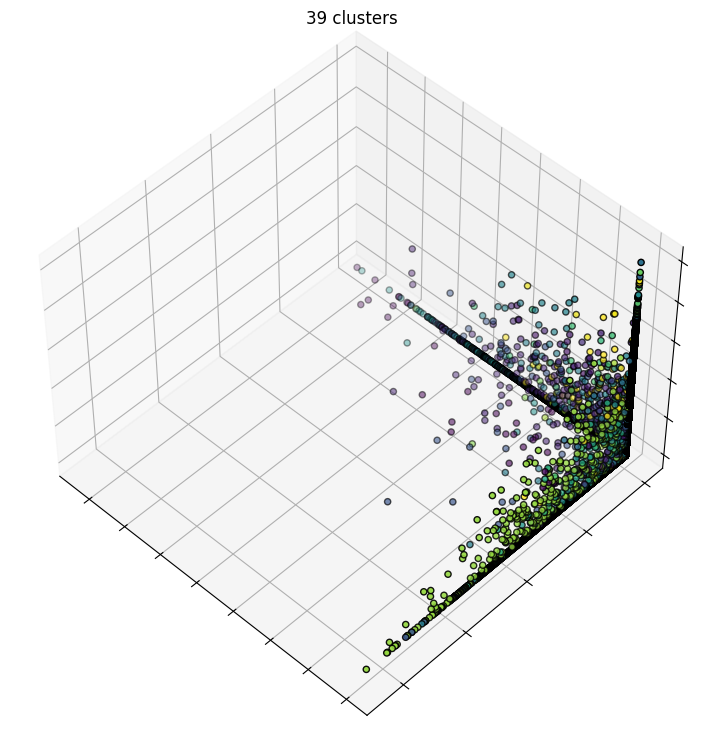

/Users/samanthajohn/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/150
3710/3710 [==============================] - 5s 1ms/step - loss: 2.7946 - accuracy: 0.2271 - val_loss: 1.6457 - val_accuracy: 0.5694
Epoch 2/150
3710/3710 [==============================] - 4s 1ms/step - loss: 1.5900 - accuracy: 0.4781 - val_loss: 1.0201 - val_accuracy: 0.7153
Epoch 3/150
3710/3710 [==============================] - 4s 1ms/step - loss: 1.2259 - accuracy: 0.5823 - val_loss: 0.8002 - val_accuracy: 0.7650
Epoch 4/150
3710/3710 [==============================] - 4s 1ms/step - loss: 1.0557 - accuracy: 0.6348 - val_loss: 0.6804 - val_accuracy: 0.7960
Epoch 5/150
3710/3710 [==============================] - 4s 1ms/step - loss: 0.9444 - accuracy: 0.6732 - val_loss: 0.6058 - val_accuracy: 0.8157
Epoch 6/150
3710/3710 [==============================] - 4s 1ms/step - loss: 0.8677 - accuracy: 0.6961 - val_loss: 0.5576 - val_accuracy: 0.8267
Epoch 7/150
3710/3710 [==============================] - 4s 1ms/step - loss: 0.8150 - accuracy: 0.7133 - val_loss: 0.5212 - val_ac

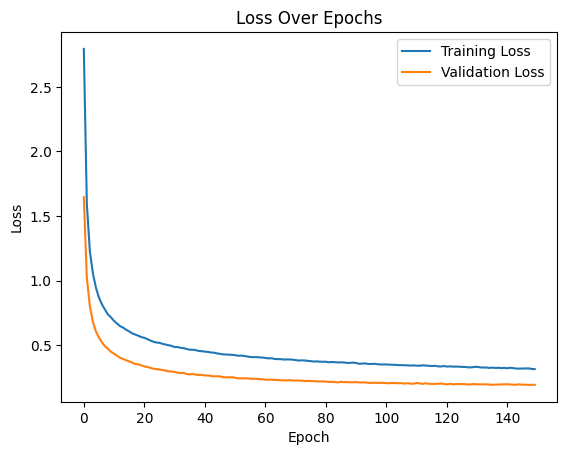

1/1 [==============================] - 0s 10ms/step


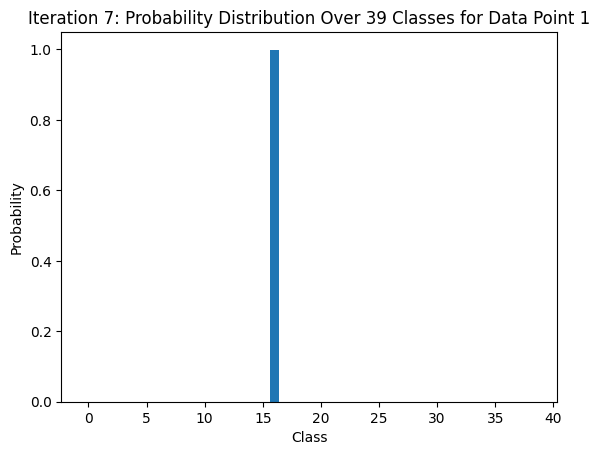

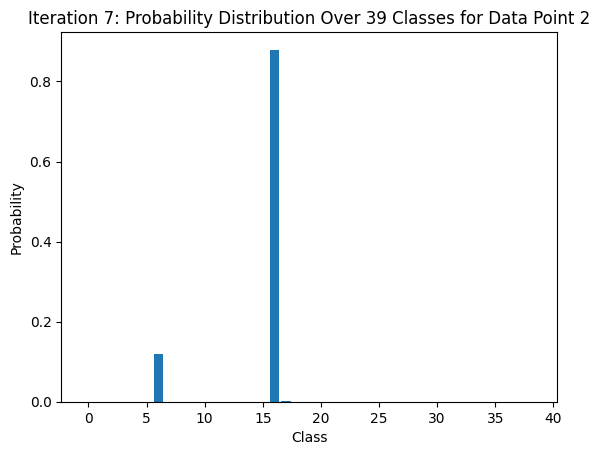

In [61]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

n_iterations = 7  # No. of iterations of the entire semi-supervised pipeline
n_clusters = 39

backprop_weights = None
backprop_biases = None

input_shape = (39, 11, 1)
cnn_model = CustomCNN(input_shape)

for iteration in range(n_iterations):
    if iteration == 0:
        X, data = load_data('/Users/dev_feat_encoded.pkl', sample_ratio=1, verbose=False)
    
    X_features, cnn_model = extract_features_cnn(X, cnn_model=cnn_model, verbose=True, backprop_weights=backprop_weights, backprop_biases=backprop_biases)

    pseudo_labels = cluster_data(X_features, data, n_clusters, CLUSTERS_NUM=39, dev=1,iteration=iteration, verbose=False)
    
    input_shape = X_features.shape[1:]  
    classification_model = train_classification_model(X_features, pseudo_labels, input_shape, n_clusters)
    
    backprop_weights = []
    backprop_biases = []
    for layer in classification_model.layers:
        if isinstance(layer, Dense):
            weights, biases = layer.get_weights()
            backprop_weights.append(weights)
            backprop_biases.append(biases)

    for i in range(2):
        data_point = X_features[i:i+1]  
        predictions = classification_model.predict(data_point)
        plt.figure(i)
        plt.bar(range(n_clusters), predictions[0])
        plt.xlabel('Class')
        plt.ylabel('Probability')
        plt.title(f'Iteration {iteration + 1}: Probability Distribution Over {n_clusters} Classes for Data Point {i+1}')
    plt.show()

-----------------------------------------------------------------------------------------------------------------------------------